In [1]:
import numpy as np
import glob
from os.path import basename
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon, ttest_ind, ttest_rel
import h5py
from matplotlib.backends.backend_pdf import PdfPages
import logomaker
import sys
sys.path.append('../code')
from utils import load_DeepSTARR_data

2024-09-20 09:54:14.955116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 09:54:15.832782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/lib
2024-09-20 09:54:15.832858: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/lib
2024-09-20 09:54:15.832864: W tensorflow/compiler/tf2tensorrt/util

# Helper functions 

In [2]:
def parse_rmse_plotdf(ensemble_rmse, distilled_rmse):
    '''
    given lists of attribution rmse for ensemble of models and distilled models
    parse a df for plotting
    '''

    # load all euclidean distances for individual models
    ensemble_rmse_arr = np.transpose(np.stack([np.load(f) for f in ensemble_rmse]))
    # load all distances for distilled models
    distilled_rmse_arr = np.transpose(np.stack([np.load(f) for f in distilled_rmse]))
    
    ensemble_rmse_df = pd.DataFrame(ensemble_rmse_arr)
    ensemble_rmse_df['model'] = 'original'
    ensemble_rmse_df['seq_ix'] = ensemble_rmse_df.index
    distilled_rmse_df = pd.DataFrame(distilled_rmse_arr)
    distilled_rmse_df['model'] = 'distilled'
    distilled_rmse_df['seq_ix'] = distilled_rmse_df.index


    # combine 
    all_dist_df = pd.concat([ensemble_rmse_df, distilled_rmse_df])
    # melt
    # plotdf = all_dist_df.melt(id_vars='model', var_name='model_ix', value_name='rmse')
    plotdf = all_dist_df.melt(id_vars=['model','seq_ix'], var_name='model_ix', value_name='rmse')
    plotdf['model_ix'] = plotdf['model_ix']+1

    # wilcox test
    ensemble_dist_flat = ensemble_rmse_arr.flatten()
    distilled_dist_flat = distilled_rmse_arr.flatten()
    res = wilcoxon(ensemble_dist_flat, distilled_dist_flat)
    return plotdf, res
    # return all_dist_df, res

def get_variance_plotdf(ensemble_std, distilled_std):
    stdev_df = pd.DataFrame(data=np.hstack((np.expand_dims(ensemble_std, axis=1), np.expand_dims(distilled_std, axis=1))), columns=['original', 'distilled'])
    stdev_plotdf = pd.melt(stdev_df, var_name='model', value_name='stdev')
    return stdev_plotdf

def get_plotdf(method, enhancer):
    ensemble_rmse = [f"../results/DeepSTARR_ensemble_NEW/{ix}_top1000_{enhancer}_{method}_euclidean_dist.npy" for ix in range(1,11)]
    distilled_rmse = [f"../results/DeepSTARR_ensemble_NEW/distilled_with_std/{ix}_top1000_{enhancer}_{method}_euclidean_dist.npy" for ix in range(1,11)]
    rmse_plotdf, rmse_wilcox = parse_rmse_plotdf(ensemble_rmse, distilled_rmse)
    return rmse_plotdf, rmse_wilcox

In [3]:
def wilcox_test(plotdf, metric='rmse'):
    '''
    given plotdf, run wilcox test comparing original to distilled models
    '''
    original = plotdf[plotdf['model']=='original'][metric].values.flatten()
    distilled = plotdf[plotdf['model']=='distilled'][metric].values.flatten()
    res = wilcoxon(original, distilled)
    return res

# DeepSTARR (SHAP)
## Dev

In [4]:
method='shap'
enhancer='Dev'

# load rmse data 
dev_shap_rmse_plotdf, dev_shap_rmse_wilcox = get_plotdf(method, enhancer)
# parse rmse results for boxplot version
dev_shap_rmse_per_model_avg_boxplot_df = dev_shap_rmse_plotdf.groupby(['model','model_ix'])['rmse'].mean().reset_index()

# map original -> individual
mapper = {'distilled':'distilled',
          'original':'individual'}
dev_shap_rmse_per_model_avg_boxplot_df['model'] = dev_shap_rmse_per_model_avg_boxplot_df['model'].map(mapper)

# load std data 
ensemble_dev_shap_std = np.load(f"../results/DeepSTARR_ensemble_NEW/top1000_{enhancer}_{method}_stdev.npy")
distilled_dev_shap_std = np.load(f"../results/DeepSTARR_ensemble_NEW/distilled_with_std/top1000_{enhancer}_{method}_stdev.npy")
dev_shap_var_plotdf = get_variance_plotdf(ensemble_dev_shap_std, distilled_dev_shap_std)



In [5]:
# calculate t-test for RMSE
t, p_val = ttest_ind(dev_shap_rmse_per_model_avg_boxplot_df[dev_shap_rmse_per_model_avg_boxplot_df['model']=='distilled']['rmse'].values, 
                     dev_shap_rmse_per_model_avg_boxplot_df[dev_shap_rmse_per_model_avg_boxplot_df['model']=='individual']['rmse'].values)
# calculate t-test for variability
_, var_p = ttest_rel(dev_shap_var_plotdf[dev_shap_var_plotdf['model']=='original']['stdev'].values,
                     dev_shap_var_plotdf[dev_shap_var_plotdf['model']=='distilled']['stdev'].values)


## Hk

In [7]:
method='shap'
enhancer='Hk'

# load data 
hk_shap_rmse_plotdf, hk_shap_rmse_wilcox = get_plotdf(method, enhancer)
# parse rmse results for boxplot version
hk_shap_rmse_per_model_avg_boxplot_df = hk_shap_rmse_plotdf.groupby(['model','model_ix'])['rmse'].mean().reset_index()
# map original -> individual
mapper = {'distilled':'distilled',
          'original':'individual'}

hk_shap_rmse_per_model_avg_boxplot_df['model'] = hk_shap_rmse_per_model_avg_boxplot_df['model'].map(mapper)

# calculate t-test for RMSE
_, p_hk_shap_rmse = ttest_ind(hk_shap_rmse_per_model_avg_boxplot_df[hk_shap_rmse_per_model_avg_boxplot_df['model']=='distilled']['rmse'].values, 
                               hk_shap_rmse_per_model_avg_boxplot_df[hk_shap_rmse_per_model_avg_boxplot_df['model']=='individual']['rmse'].values)
print(p_hk_shap_rmse)

# get plotdf 
ensemble_hk_shap_std = np.load(f"../results/DeepSTARR_ensemble_NEW/top1000_{enhancer}_{method}_stdev.npy")
distilled_hk_shap_std = np.load(f"../results/DeepSTARR_ensemble_NEW/distilled_with_std/top1000_{enhancer}_{method}_stdev.npy")
hk_shap_var_plotdf = get_variance_plotdf(ensemble_hk_shap_std, distilled_hk_shap_std)

# calculate t-test for variability
_, p_hk_shap_var = ttest_rel(hk_shap_var_plotdf[hk_shap_var_plotdf['model']=='original']['stdev'].values,
                              hk_shap_var_plotdf[hk_shap_var_plotdf['model']=='distilled']['stdev'].values)
print(p_hk_shap_var)

3.6627369004241327e-09
0.0


# Plot similarity together

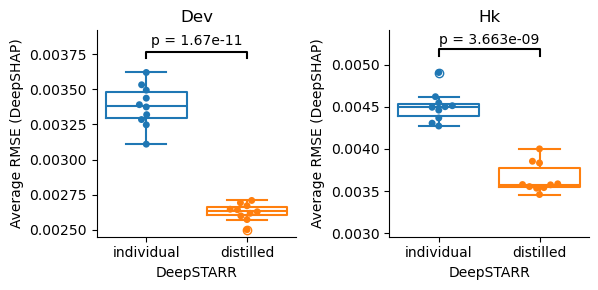

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))


palette = {'distilled':'tab:orange', 'individual':'tab:blue'}

# plot dev
order = ['individual', 'distilled']  
sns.boxplot(data=dev_shap_rmse_per_model_avg_boxplot_df, x='model', y='rmse', hue='model', ax=axs[0], fill=False, palette=palette, order=order)
sns.swarmplot(data=dev_shap_rmse_per_model_avg_boxplot_df, x='model', y='rmse', hue='model', ax=axs[0], dodge=False, legend=False, palette=palette, order=order)\
# axs[0].set_title('DeepSHAP similarity to ensemble')
axs[0].set_title('Dev')
axs[0].set_ylim([dev_shap_rmse_per_model_avg_boxplot_df['rmse'].min()-0.00005, dev_shap_rmse_per_model_avg_boxplot_df['rmse'].max()+0.0003])

# add p-value label
x1, x2 = 0, 1
y, h = axs[0].get_ylim()[1]-0.0002, (axs[0].get_ylim()[1] - axs[0].get_ylim()[0]) * 0.03
axs[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
axs[0].text((x1+x2)*.5, y+h+0.00003, f"p = {p_val:.4g}", ha='center', va='bottom')

# plot hk
sns.boxplot(data=hk_shap_rmse_per_model_avg_boxplot_df, x='model', y='rmse', hue='model', ax=axs[1], fill=False, order=order, palette=palette)
sns.swarmplot(data=hk_shap_rmse_per_model_avg_boxplot_df, x='model', y='rmse', hue='model', ax=axs[1], dodge=False, legend=False, order=order, palette=palette)
axs[1].set_ylim([hk_shap_rmse_per_model_avg_boxplot_df['rmse'].min()-0.0005, 
                 hk_shap_rmse_per_model_avg_boxplot_df['rmse'].max()+0.0005])
# if method == 'shap':
#     axs[1].set_title('DeepSHAP similarity to ensemble')
# else:
#     axs[1].set_title('Saliency similarity to ensemble')
axs[1].set_title('Hk')

x1, x2 = 0, 1
y, h = axs[1].get_ylim()[1]-0.0003, (axs[1].get_ylim()[1] - axs[1].get_ylim()[0]) * 0.03
axs[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
axs[1].text((x1+x2)*.5, y+h+0.00003, f"p = {p_hk_shap_rmse:.4g}", ha='center', va='bottom')


for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('DeepSTARR')
    ax.set_ylabel('Average RMSE (DeepSHAP)')
    
# fig.suptitle(f'DeepSHAP similarity to DeepSTARR ensemble for top 1000 seqs')
fig.tight_layout()

fig.show()
fig.savefig("DeepSTARR_similarity.pdf")


# Plot variability

0.03
0.21


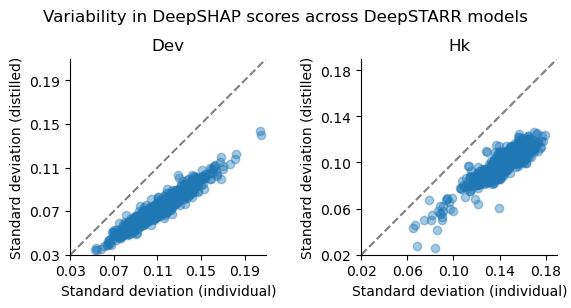

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

# plot dev
# scatterplot
axs[0].scatter(x=dev_shap_var_plotdf[dev_shap_var_plotdf['model']=='original']['stdev'].values,
               y=dev_shap_var_plotdf[dev_shap_var_plotdf['model']=='distilled']['stdev'].values,
               alpha=0.4)
axs[0].set_aspect('equal')
axs[0].set_title('Dev')
# Determine the min and max range
min_range = np.floor(min(np.min(dev_shap_var_plotdf[dev_shap_var_plotdf['model']=='original']['stdev'].values),
                         np.min(dev_shap_var_plotdf[dev_shap_var_plotdf['model']=='distilled']['stdev'].values))*100)/100
max_range = round(max(np.max(dev_shap_var_plotdf[dev_shap_var_plotdf['model']=='original']['stdev'].values), 
                      np.max(dev_shap_var_plotdf[dev_shap_var_plotdf['model']=='distilled']['stdev'].values)), 2)

# Set x and y limits to be the same
print(min_range)
print(max_range)
axs[0].set_xlim(min_range, max_range)
axs[0].set_ylim(min_range, max_range)
# Set the same ticks for both axes
ticks = np.arange(min_range, max_range+0.01, 0.04)  # +0.1 to include the upper limit
axs[0].set_xticks(ticks)
axs[0].set_yticks(ticks)
# add identity line
axs[0].plot([min_range, max_range], [min_range, max_range], color='grey', linestyle='--')

# plot hk
# scatterplot
axs[1].scatter(x=hk_shap_var_plotdf[hk_shap_var_plotdf['model']=='original']['stdev'].values,
               y=hk_shap_var_plotdf[hk_shap_var_plotdf['model']=='distilled']['stdev'].values, alpha=0.4)
axs[1].set_aspect('equal')

# # Determine the min and max range
min_range = np.floor(min(np.min(hk_shap_var_plotdf[hk_shap_var_plotdf['model']=='original']['stdev'].values),
                         np.min(hk_shap_var_plotdf[hk_shap_var_plotdf['model']=='distilled']['stdev'].values))*100)/100
max_range = round(max(np.max(hk_shap_var_plotdf[hk_shap_var_plotdf['model']=='original']['stdev'].values), 
                      np.max(hk_shap_var_plotdf[hk_shap_var_plotdf['model']=='distilled']['stdev'].values)), 2) + 0.01

# Set x and y limits to be the same
axs[1].set_xlim(min_range, max_range)
axs[1].set_ylim(min_range, max_range)

# Set the same ticks for both axes
ticks = np.arange(min_range, max_range, 0.04)  # +0.1 to include the upper limit
axs[1].set_xticks(ticks)
axs[1].set_yticks(ticks)

# add identity line
axs[1].plot([min_range, max_range], [min_range, max_range], color='grey', linestyle='--')

# annotate 
axs[1].set_title('Hk')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Standard deviation (individual)')
    ax.set_ylabel('Standard deviation (distilled)')
    
fig.suptitle('Variability in DeepSHAP scores across DeepSTARR models')
fig.tight_layout()
fig.show() 
fig.savefig("DeepSTARR_attribution_variability.png", dpi=300)